# SpeakUp2.0: Analysing Audio Signals 

### 0. Import Necessary Packages 

In [1]:
import math #basic operations
import numpy as np #basic operations
import pandas as pd #data wrangling
import csv #csv saving
import os #some basic functions for inspecting folder structure etc.
from os import listdir
from os.path import isfile, join
import glob as glob
import matplotlib.pyplot as plt
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog, messagebox  # GUI toolkit to open and save files
from scipy.signal import butter, filtfilt, iirnotch
import librosa
import librosa.display
import tempfile
import shutil
import tqdm
from scipy.ndimage import uniform_filter1d


print("Everything imported successfully")


Everything imported successfully


### 1. Defyining key Directories, Variables & Functions 

In [12]:
## DIRECTORIES
input_audio_file = r"Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs"
input_audio_baseline = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\manual_startend"
output_audio_file = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_output"
output_audio_baseline = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures"
output_audio_picture = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_figures"
figures_results = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\figures_results'
output_results = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\results' 

output_rms = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\rms_output"
figures_rms = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\figures_rms"
output_silence = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\silence_output"

print('We will be extracting the audio files from the following directory: ', input_audio_file) 
print('The extracted audio files will be saved in the following directory: ', output_audio_file)

## VARIABLES
keyword = 'denoised' #keyword to search for in the file name


## FUNCTIONS

# Function to apply a lowpass Butterworth filter to data using filtfilt (zero-phase filtering)
def butter_lowpass_filter(data, cutoff, fs, order=2):
    """
    Designs and applies a lowpass Butterworth filter to the given data using zero-phase filtering.

    Parameters:
    - data (array-like): The input signal to be filtered.
    - cutoff (float): The cutoff frequency in Hz.
    - fs (float): The sampling frequency in Hz.
    - order (int, optional): The order of the filter. Default is 2.

    Returns:
    - y (array-like): The filtered signal.
    """
    if fs <= 0 or cutoff <= 0:
        raise ValueError("Sampling frequency and cutoff frequency must be positive values.")
    if fs <= 2 * cutoff:
        raise ValueError("Sampling frequency must be greater than twice the cutoff frequency to avoid aliasing.")

    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low')  # Create a lowpass Butterworth filter
    y = filtfilt(b, a, data)  # Apply filter using filtfilt to get zero-phase filtering (i.e., no phase shift)
    return y
print("butter_lowpass_filter function defined successfully")

# Function to apply a bandpass Butterworth filter to data using filtfilt (zero-phase filtering)
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    """
    Designs and applies a bandpass Butterworth filter to the given data using zero-phase filtering.

    Parameters:
    - data (array-like): The input signal to be filtered.
    - lowcut (float): The lower cutoff frequency in Hz.
    - highcut (float): The upper cutoff frequency in Hz.
    - fs (float): The sampling frequency in Hz.
    - order (int, optional): The order of the filter. Default is 2.

    Returns:
    - y (array-like): The filtered signal.
    """
    if fs <= 0 or lowcut <= 0 or highcut <= 0:
        raise ValueError("Sampling frequency and cutoff frequencies must be positive values.")
    if lowcut >= highcut:
        raise ValueError("Lower cutoff frequency must be less than the upper cutoff frequency.")
    if fs <= 2 * highcut:
        raise ValueError("Sampling frequency must be greater than twice the upper cutoff frequency to avoid aliasing.")

    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    low = lowcut / nyquist  # Normalize the lower cutoff frequency
    high = highcut / nyquist  # Normalize the upper cutoff frequency
    b, a = butter(order, [low, high], btype='band')  # Create a bandpass Butterworth filter
    y = filtfilt(b, a, data)  # Apply filter using filtfilt to get zero-phase filtering (i.e., no phase shift)
    return y
print("butter_bandpass_filter function defined successfully")


# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    """
    Extracts the amplitude envelope from an audio file.

    This function loads an audio file, applies bandpass and lowpass filters to extract the amplitude envelope,
    and scales the result between 0 and 1.

    Parameters:
    - audiofilename (str): Path to the audio file.

    Returns:
    - data (array-like): The amplitude envelope of the audio signal, scaled between 0 and 1.
    - sr (int): The sampling rate of the audio file.
    """
    # Load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None)
    # Bandpass filter 400-4000Hz to isolate frequencies of interest
    data = butter_bandpass_filter(audio, 400, 4000, sr, order=2)
    # Rectify the signal to provide tha absolute value ( instantaneous amplitude )
    data = np.abs(data)
    # Lowpass filter 10Hz to extract the envelope by allowing only the very slow variations (below 10 Hz) to pass.
    data = butter_lowpass_filter(data, 10, sr, order=2)
    # Scale from 0 to 1 for normalization
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr
print("amp_envelope function defined successfully")

window_time = 25
sampling_rate = 16000
window_size = (window_time / 1000) * sampling_rate
print('Window size in samples: ', window_size)

# Function to calculate RMS energy
def rms_energy(audio, window_size, normalize=False):
    """
    Calculate the RMS energy of the audio signal in a sliding window.
    
    Parameters:
    - audio (array-like): The input audio signal.
    - window_size (int): The size of the window in samples.
    - normalize (bool): Whether to normalize RMS to range [0, 1]. Default is False.
    
    Returns:
    - rms (array-like): The RMS energy of the signal.
    """
    # Trim the signal to fit the window size (avoid padding)
    trimmed_length = len(audio) - (len(audio) % window_size)
    trimmed_audio = audio[:trimmed_length]

    # Compute RMS energy in sliding windows
    rms = np.sqrt(np.mean(np.reshape(trimmed_audio**2, (-1, window_size)), axis=1))
    
    # Optional normalization
    if normalize:
        rms = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))
    
    return rms

print("rms_energy function defined successfully")


# Function to detect silence based on RMS
def detect_silence(rms_values, rms_time, window_duration, sr, threshold=1e-3):
    """
    Detect periods of silence where the RMS values are below a threshold for a defined window duration.
    """
    window_size = int(window_duration * sr / (sr * 0.025))  # Convert window duration to number of RMS samples
    rms_smoothed = uniform_filter1d(rms_values, size=window_size, mode='nearest')  # Apply smoothing with boundary handling
    
    silence_mask = rms_smoothed < threshold
    
    # Find indices where silence occurs
    silence_periods = []
    in_silence = False
    start_time = None

    for i, is_silent in enumerate(silence_mask):
        if i >= len(rms_time):  # Ensure we don't exceed the length of rms_time
            break
        if is_silent and not in_silence:
            # Start of a silence period
            in_silence = True
            start_time = rms_time[i]
        elif not is_silent and in_silence:
            # End of a silence period
            in_silence = False
            end_time = rms_time[i]
            silence_periods.append((start_time, end_time))
    
    # If the silence extends till the end, close it
    if in_silence:
        silence_periods.append((start_time, rms_time[-1]))
    
    return silence_periods



def detect_silence_direct(rms_values, rms_time, sr, window_duration=0.025, threshold=1e-2, min_silence_duration=0.5):
    """
    Detect periods of silence where the RMS values are below a threshold for a minimum silence duration.
    
    Parameters:
    - rms_values: The RMS values of the signal.
    - rms_time: The corresponding time values for the RMS.
    - sr: Sampling rate of the original audio signal.
    - window_duration: The duration of the RMS window in seconds (e.g., 0.025 for a 25 ms window).
    - threshold: RMS threshold below which the signal is considered silence.
    - min_silence_duration: The minimum duration (in seconds) to consider a silence period.
    
    Returns:
    - List of (start_time, end_time) tuples representing silence periods.
    """
    # Calculate the frame rate based on the RMS window size
    rms_frame_rate = 1 / window_duration  # In Hz (e.g., 1 / 0.025 = 40 Hz)
    
    # Find where RMS is below the threshold
    silence_mask = rms_values < threshold
    
    # Minimum number of consecutive RMS frames for a valid silence period
    min_silence_samples = int(min_silence_duration * rms_frame_rate)
    
    silence_periods = []
    in_silence = False
    start_time = None
    silence_start_idx = None

    for i, is_silent in enumerate(silence_mask):
        if is_silent and not in_silence:
            # Start of a potential silence period
            in_silence = True
            start_time = rms_time[i]
            silence_start_idx = i
        elif not is_silent and in_silence:
            # End of a silence period
            in_silence = False
            end_time = rms_time[i]
            # Only record the silence period if it's longer than the minimum silence duration
            if (i - silence_start_idx) >= min_silence_samples:
                silence_periods.append((start_time, end_time))
    
    # If the silence extends till the end, close it
    if in_silence and (len(silence_mask) - silence_start_idx) >= min_silence_samples:
        silence_periods.append((start_time, rms_time[-1]))
    
    return silence_periods



We will be extracting the audio files from the following directory:  Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs
The extracted audio files will be saved in the following directory:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_output
butter_lowpass_filter function defined successfully
butter_bandpass_filter function defined successfully
amp_envelope function defined successfully
Window size in samples:  400.0
rms_energy function defined successfully


### 2 Process Audio Baseline to extract Amplitude and RSM Energy 

In [19]:
for root, dirs, files in os.walk(input_audio_baseline):  # Loop through all files in the input directory
   
    for file in files:                                  # Loop through all files in the input directory
        
        if 'Mic' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
            print("Processing LSL file: ", os.path.basename(file))

            LSL_filename = os.path.join(root, file)
            
            LSL_data = pd.read_csv(LSL_filename)
            
            LSL_Time = LSL_data['LSL_Time']
            
 
       
        if keyword in file and file.endswith(".wav"):   # Check if the file contains the keyword and is a .wav file
            
            # Extract relevant key words from file name to match later with cloud export folder
            fnam = os.path.basename(file)[:-4]    # Extract the file name from the path and assings it to fnam, whilst removing the '.wav' extension (i.e., the last 4 characters in the string)
            participant_num = '_'.join(fnam.split('_')[0:2])  # Extract the participant number from the file name by splitting the string at the underscores and selecting the first two elements
            day_num = fnam.split('_')[2]  # Extract the day number from the file name by splitting the string at the underscores and selecting the third element
                        
            audiofilename = os.path.join(root, file)
            
            # Get the start and end time of the LSL 
            start_time = LSL_Time.iloc[0]
            end_time = LSL_Time.iloc[-1]
            duration = end_time - start_time  # Total duration of the LSL time
            
            
            print("Processing file: ", os.path.basename(audiofilename))
            rawaudio, sr = librosa.load(audiofilename, sr=None)
            print('The sampling rate of the raw audio is', sr)
            
            
            print("Extracting amplitude envelope...")
            ampv, sr = amp_envelope(audiofilename)

            # Smooth the amplitude envelope using a moving average filter
            ampv = pd.Series(ampv).rolling(window=100, min_periods=1).mean()
            
            print("Calculating RMS energy...")
            rms_energy_values = rms_energy(rawaudio, window_size=int(sr * 0.025))  # 25ms window
            
            # Save the Raw Audio, Amplitude Envelope, 
            audio_amp_df = pd.DataFrame({
                'Time (s)': LSL_Time - LSL_Time.iloc[0],
                'audio': rawaudio, 
                'envelope': ampv,
            })
            
            # Sav the RMS energy as a dataframe
            rms_df = pd.DataFrame({
                'Time (s)':  np.linspace(start_time, end_time, len(rms_energy_values)),
                'rms_energy': rms_energy_values,
            })

            # Save the dataframe as a CSV
            outputfilename = f"{participant_num}_{day_num}_baseline_audio_amp.csv"
            outputfilepath = os.path.join(output_audio_baseline, outputfilename)
            print("Saving audio, amplitude envelope, and RMS energy to: ", outputfilepath)
            audio_amp_df.to_csv(outputfilepath, index=False)
            
            # Save the RMS energy as a dataframe
            outputfilename = f"{participant_num}_{day_num}_baseline_rms_energy.csv"
            outputfilepath = os.path.join(output_audio_baseline, outputfilename)
            print("Saving RMS energy to: ", outputfilepath)
            rms_df.to_csv(outputfilepath, index=False)
            
            
            
print("All files processed successfully!")

            
            
            

Processing LSL file:  pilot_01_d2_audio_baseline_Mic_Start_End.csv
Processing file:  pilot_01_d2_audio_baseline_Mic_Start_End_denoised.wav
The sampling rate of the raw audio is 16000
Extracting amplitude envelope...
Calculating RMS energy...
Saving audio, amplitude envelope, and RMS energy to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_01_d2_baseline_audio_amp.csv
Saving RMS energy to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_01_d2_baseline_rms_energy.csv
Processing LSL file:  pilot_01_d3_audio_baseline_Mic_Start_End.csv
Processing file:  pilot_01_d3_audio_baseline_Mic_Start_End_denoised.wav
The sampling rate of the raw audio is 16000
Extracting amplitude envelope...
Calculating RMS energy...
Saving audio, amplitude envelope, and RMS energy to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_01_d3_baseline_audio_amp.csv
Saving RMS energy to:  Z:\Davide_Mul

### 3. Now we Process the Speech Audio, Relative to the Baseline. Here we do RMS_energy and Silence Detection 

In [21]:

results = []
for root, dirs, files in os.walk(input_audio_file):  
    for file in files:  
        if 'Mic' in file and file.endswith(".csv"):
            print("Processing LSL file: ", os.path.basename(file))

            LSL_filename = os.path.join(root, file)
            LSL_data = pd.read_csv(LSL_filename)
            LSL_Time = LSL_data['LSL_Time']
        
        if keyword in file and file.endswith(".wav"):
            
            # Extract relevant key words from file name
            fnam = os.path.basename(file)[:-4]    
            participant_num = '_'.join(fnam.split('_')[0:2])  
            day_num = fnam.split('_')[2]  
            condition = '_'.join(fnam.split('_')[6:10])  
            
            audiofilename = os.path.join(root, file)
            print("Processing file: ", os.path.basename(audiofilename))
            rawaudio, sr = librosa.load(audiofilename, sr=None)
            print('The sampling rate of the raw audio is', sr)
            raw_audio_time = LSL_Time - LSL_Time.iloc[0]
            
            # Calculate RMS for the speech file
            print("Calculating RMS energy for the speech...")
            rms_speech = rms_energy(rawaudio, window_size=int(sr * 0.025))  # 25ms window
            mean_rms_speech = np.mean(rms_speech)  # Compute mean RMS for speech

            
            ### SILENCE DETECTION ###
            # Calculate silence periods in the speech file based on RMS
            print("Detecting silence periods in the speech...")
            rms_time = np.linspace(0, (LSL_Time.iloc[-1] - LSL_Time.iloc[0]), len(rms_speech))
            # silence_periods = detect_silence(rms_speech, rms_time, window_duration= 0.5, sr=sr)
            silence_periods = detect_silence_direct(rms_speech, rms_time, sr, threshold = 0.005, min_silence_duration = 1.0)

            total_silence_duration = sum([end - start for start, end in silence_periods])
            print(f"Total Silence Duration: {total_silence_duration:.2f} seconds")

            
            # Load corresponding baseline audio and RMS files
            baseline_audio_filename = f"{participant_num}_{day_num}_baseline_audio_amp.csv"
            baseline_audio_filepath = os.path.join(output_audio_baseline, baseline_audio_filename)
            print("Loading baseline audio from: ", baseline_audio_filepath)
            baseline_rms_filename = f"{participant_num}_{day_num}_baseline_rms_energy.csv"
            baseline_rms_filepath = os.path.join(output_audio_baseline, baseline_rms_filename)
            print("Loading baseline RMS from: ", baseline_rms_filepath)


            
            try:
               # Load baseline audio and RMS values
                baseline_audio_df = pd.read_csv(baseline_audio_filepath)
                baseline_rms_df = pd.read_csv(baseline_rms_filepath)
                baseline_audio_values = baseline_audio_df['audio'].values
                baseline_rms_values = baseline_rms_df['rms_energy'].values

                baseline_audio_time = baseline_audio_df['Time (s)'].values  # Baseline time
                baseline_rsm_time = baseline_rms_df['Time (s)'].values  # Baseline time

                # Calculate the average RMS of the baseline
                baseline_rms_avg = np.mean(baseline_rms_values)
                print(f"Average baseline RMS for {participant_num} on {day_num}: {baseline_rms_avg}")

                # Calculate Relative RMS (Speech RMS / Baseline RMS Avg)
                relative_rms = rms_speech / baseline_rms_avg
                


                # Create a time vector for the RMS data
                rms_time = np.linspace(0, (LSL_Time.iloc[-1] - LSL_Time.iloc[0]), len(rms_speech))

                # Calculate overall relative RMS
                overall_relative_rms = np.mean(relative_rms)
                
                
                # Add results to the results list for this file
                results.append({
                    'participant_num': participant_num,
                    'day_num': day_num,
                    'condition': condition,
                    'mean_rms_speech': mean_rms_speech,
                    'baseline_rms_avg': baseline_rms_avg,
                    'mean_relative_rms': overall_relative_rms,
                    'total_silence_duration': total_silence_duration
                })

                
               ### PLOTTING ###        
                plt.figure(figsize=(16, 18))  

                # Subplot 1: Baseline audio
                plt.subplot(6, 1, 1)
                plt.plot(baseline_audio_time, baseline_audio_values, color='black', lw=0.1, label='Baseline Audio')
                plt.title(f'Baseline Audio (Participant: {participant_num}, Day: {day_num})')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()

                # Subplot 2: Baseline RMS with baseline RMS average line
                plt.subplot(6, 1, 2)
                plt.plot(baseline_rsm_time, baseline_rms_values, color='red', lw=1, label='Baseline RMS')
                plt.axhline(baseline_rms_avg, color='red', linestyle='--', label=f'Baseline RMS Avg: {baseline_rms_avg:.2f}')
                plt.title('Baseline RMS')
                plt.xlabel('Time (s)')
                plt.ylabel('RMS')
                plt.legend()

                # Subplot 3: Speech raw audio
                plt.subplot(6, 1, 3)
                plt.plot(raw_audio_time, rawaudio, color='black', lw=0.1, label='Speech Raw Audio')
                plt.title(f'Speech Audio (Participant: {participant_num}, Day: {day_num})')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()

                # Subplot 4: Speech RMS with silences
                plt.subplot(6, 1, 4)
                plt.plot(rms_time, rms_speech, color='red', lw=1, label='Speech RMS')
                for (start, end) in silence_periods:
                    plt.axvspan(start, end, color='green', alpha=0.5)  # Highlight silence periods 
                plt.title('Speech RMS with Silence Periods')
                plt.xlabel('Time (s)')
                plt.ylabel('RMS')
                # Add the total silence duraction in the top right corner
                plt.text(1, 0.9, f'Silence: {total_silence_duration:.2f}', 
                         horizontalalignment='right', 
                         verticalalignment='top', 
                         transform=plt.gca().transAxes,
                         fontsize=12, color='black')

                plt.tight_layout()


                # Subplot 5: First 10 seconds of Speech RMS with silences
                plt.subplot(6, 1, 5)
                time_limit = rms_time <= 10  # Time limit for first 10 seconds
                plt.plot(rms_time[time_limit], rms_speech[time_limit], color='red', lw=1, label='Speech RMS (First 10 Seconds)')
                for (start, end) in silence_periods:
                    if start <= 10:  # Only highlight silences within the first 10 seconds
                        plt.axvspan(start, min(end, 10), color='green', alpha=0.5)
                plt.title('Speech RMS with Silence Periods (First 10 Seconds)')
                plt.xlabel('Time (s)')
                plt.ylabel('RMS')
                plt.legend()

                # Subplot 6: Relative RMS with baseline RMS average line
                plt.subplot(6, 1, 6)
                plt.plot(rms_time, relative_rms, color='purple', lw=1, label='Relative RMS')
                plt.axhline(1, color='red', linestyle='--', label=f'Baseline RMS Avg = 1.0')
                plt.title('Relative RMS (Speech / Baseline Avg)')
                plt.xlabel('Time (s)')
                plt.ylabel('Relative RMS')
                # Add the average relative RMS value in the top right corner
                plt.text(1, 0.9, f'Avg Relative RMS: {overall_relative_rms:.2f}', 
                         horizontalalignment='right', 
                         verticalalignment='top', 
                         transform=plt.gca().transAxes,
                         fontsize=12, color='black')

                plt.tight_layout()

                # Save the plot
                plot_filename = f"{participant_num}_{day_num}__{condition}_rms_comparison.png"
                plot_filepath = os.path.join(figures_rms, plot_filename)
                plt.savefig(plot_filepath)
                print(f"Plot saved to: {plot_filepath}")

                # plt.show()
                plt.close()
    
                
                # Save the relative RMS as a dataframe with overall relative RMS
                relative_rms_df = pd.DataFrame({
                    'Time (s)': rms_time,
                    'relative_rms': relative_rms,
                    'overall_relative_rms': [overall_relative_rms] * len(rms_time)  # Add this to keep the overall value for reference
                })

                # Save the relative RMS dataframe to a CSV file
                outputfilename = f"{participant_num}_{day_num}__{condition}_relative_rms.csv"
                outputfilepath = os.path.join(output_audio_file, outputfilename)
                print("Saving relative RMS to: ", outputfilepath)
                relative_rms_df.to_csv(outputfilepath, index=False)
                
                
                # Save the results to a CSV file after processing all files
                results_df = pd.DataFrame(results)
                output_results_filepath = os.path.join(output_results, 'rms_silence_summary.csv')
                results_df.to_csv(output_results_filepath, index=False)
                print(f"Summary of RMS and silence duration saved to {output_results_filepath}")
                            
            except FileNotFoundError:
                print(f"Baseline RMS file not found for {participant_num} on {day_num}. Skipping.")


Processing LSL file:  pilot_01_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start.csv
Processing file:  pilot_01_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Total Silence Duration: 19.55 seconds
Loading baseline audio from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_01_d2_baseline_audio_amp.csv
Loading baseline RMS from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_01_d2_baseline_rms_energy.csv
Average baseline RMS for pilot_01 on d2: 0.009772408279957751
Plot saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\figures_rms\pilot_01_d2__Speech_Start_SUD_1_rms_comparison.png
Saving relative RMS to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_output\pilot_01_d2__Speech_Start_SUD_1_relative_rms.csv
Summary of RMS and silence duration saved to Z:\Davide_

C:\Users\ahmar\AppData\Local\Temp\ipykernel_7252\3201896106.py:133: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\ahmar\AppData\Local\Temp\ipykernel_7252\3201896106.py:162: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\ahmar\AppData\Local\Temp\ipykernel_7252\3201896106.py:167: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_filepath)


Plot saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\figures_rms\pilot_05_d2__Speech_Start_SUD_1_rms_comparison.png
Saving relative RMS to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_output\pilot_05_d2__Speech_Start_SUD_1_relative_rms.csv
Summary of RMS and silence duration saved to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\results\rms_silence_summary.csv
Processing LSL file:  pilot_05_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start.csv
Processing file:  pilot_05_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Total Silence Duration: 5.83 seconds
Loading baseline audio from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_05_d2_baseline_audio_amp.csv
Loading baseline RMS from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_05_d2_baseline_rms_energy.csv

C:\Users\ahmar\AppData\Local\Temp\ipykernel_7252\3201896106.py:167: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(plot_filepath)


Plot saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\figures_rms\pilot_05_d2__SUD_1_End_SUD_rms_comparison.png
Saving relative RMS to:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_amp_output\pilot_05_d2__SUD_1_End_SUD_relative_rms.csv
Summary of RMS and silence duration saved to Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\results\rms_silence_summary.csv
Processing LSL file:  pilot_05_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start.csv
Processing file:  pilot_05_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Total Silence Duration: 4.55 seconds
Loading baseline audio from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_05_d2_baseline_audio_amp.csv
Loading baseline RMS from:  Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\2_AUDIO\audio_baseline\baseline_measures\pilot_05_d2_baseline_rms_energy.csv
Average b

In [35]:
print(silence_periods)

[]


### RESULTS PLOTTING. HERE I'M PLOTTING THE RMS AND SILENCES FOR THE ENTIRE SPEECH OF EACH PARTICIPANT

Processing participant session: pilot_01_d2
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day2\\pilot_01_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_01\day2\pilot_01_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

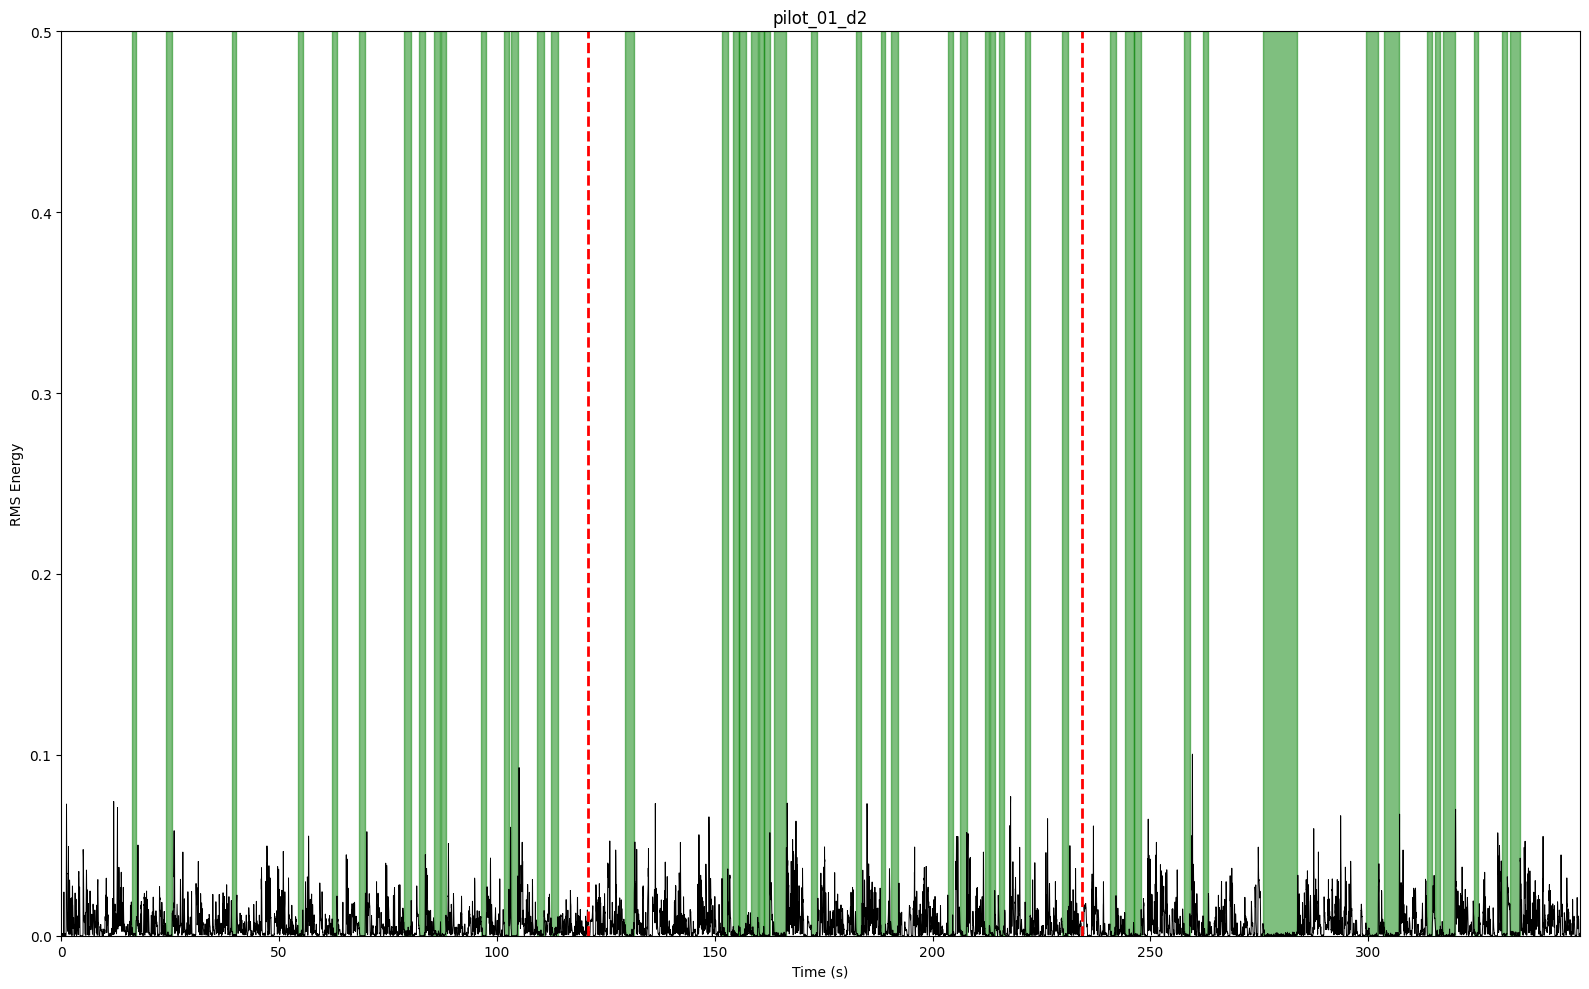

Processing participant session: pilot_01_d3
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_01\\day3\\pilot_01_d3_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_01\day3\pilot_01_d3_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

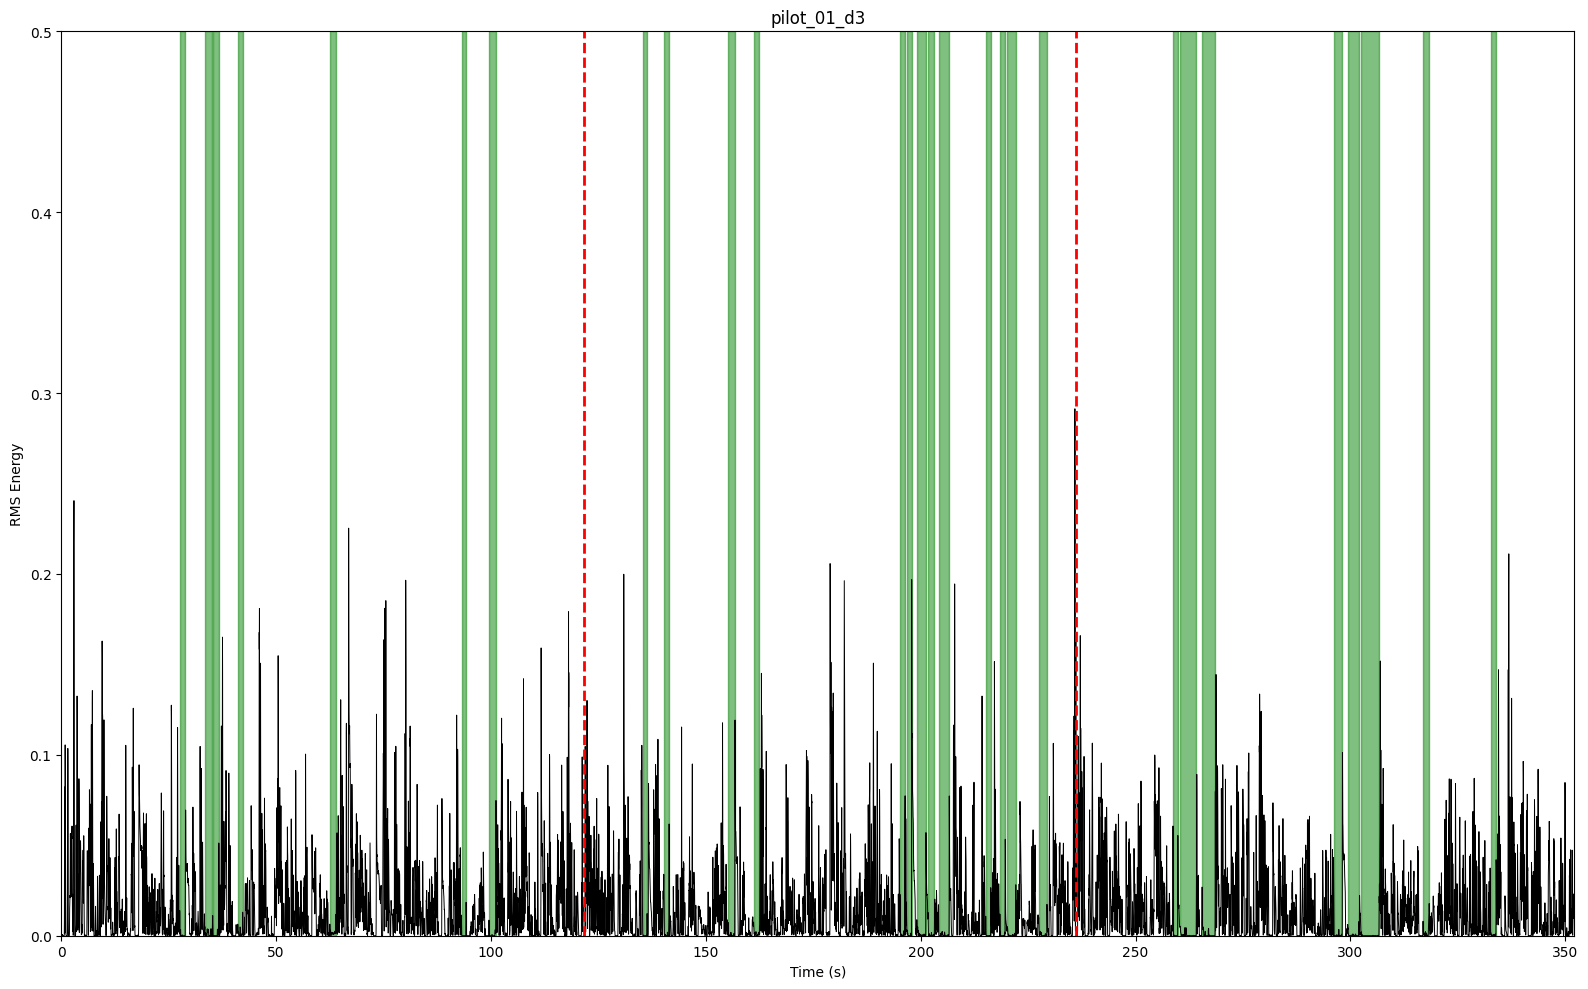

Processing participant session: pilot_02_d2
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day2\\pilot_02_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_02\day2\pilot_02_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

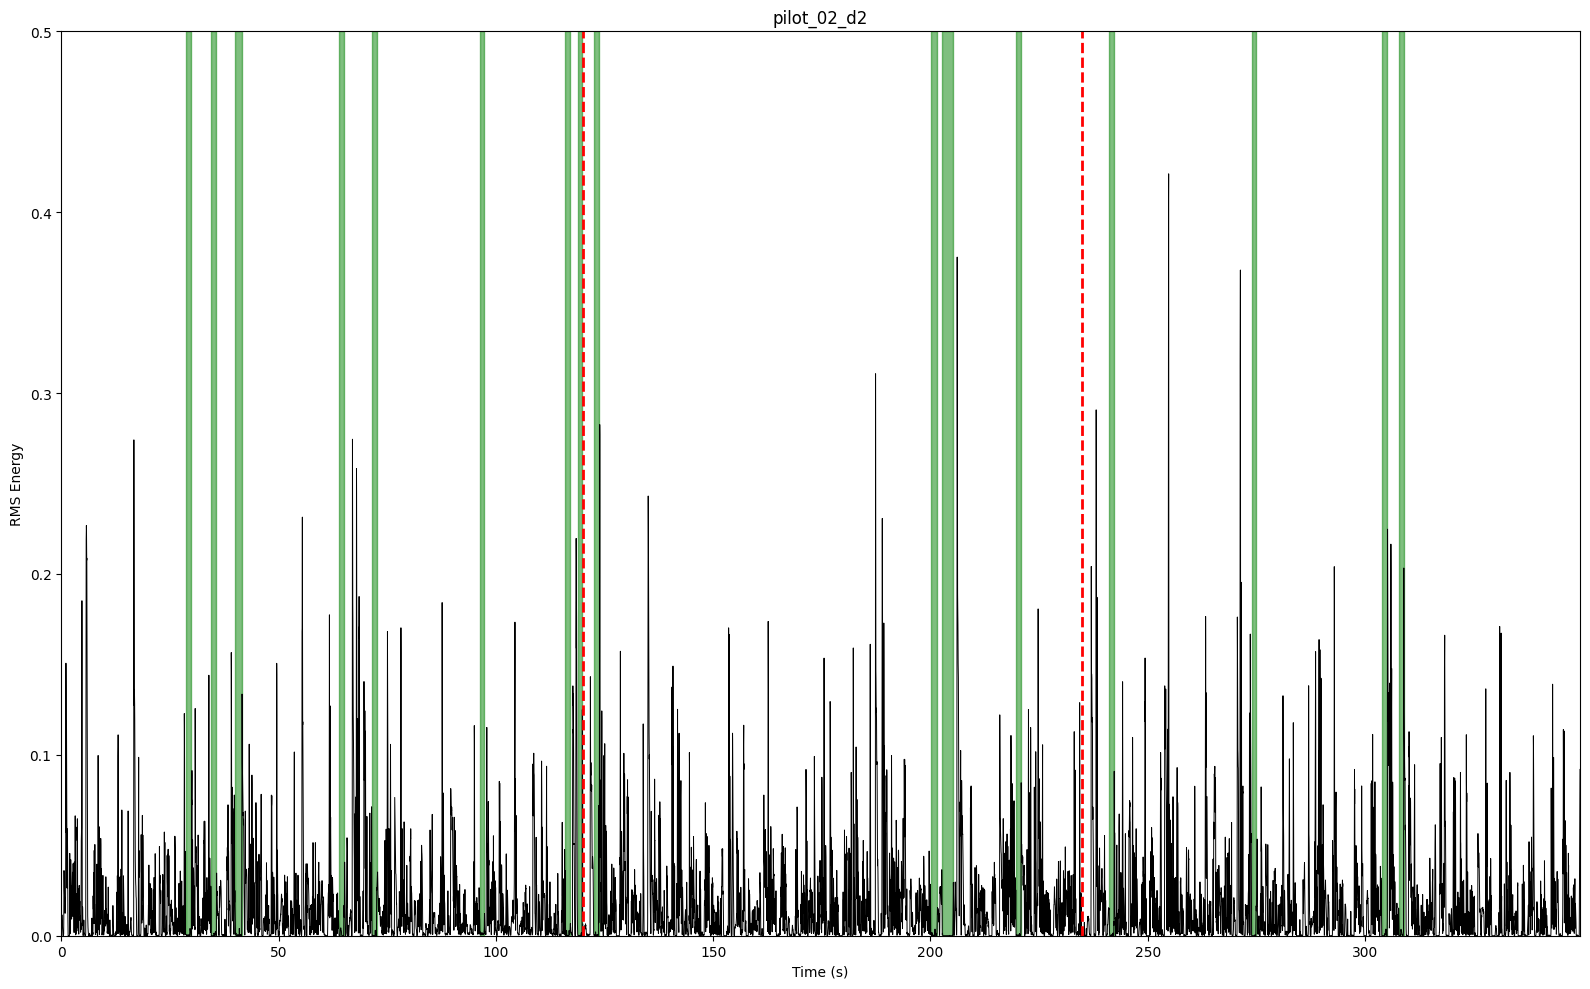

Processing participant session: pilot_02_d3
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_02\\day3\\pilot_02_d3_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_02\day3\pilot_02_d3_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

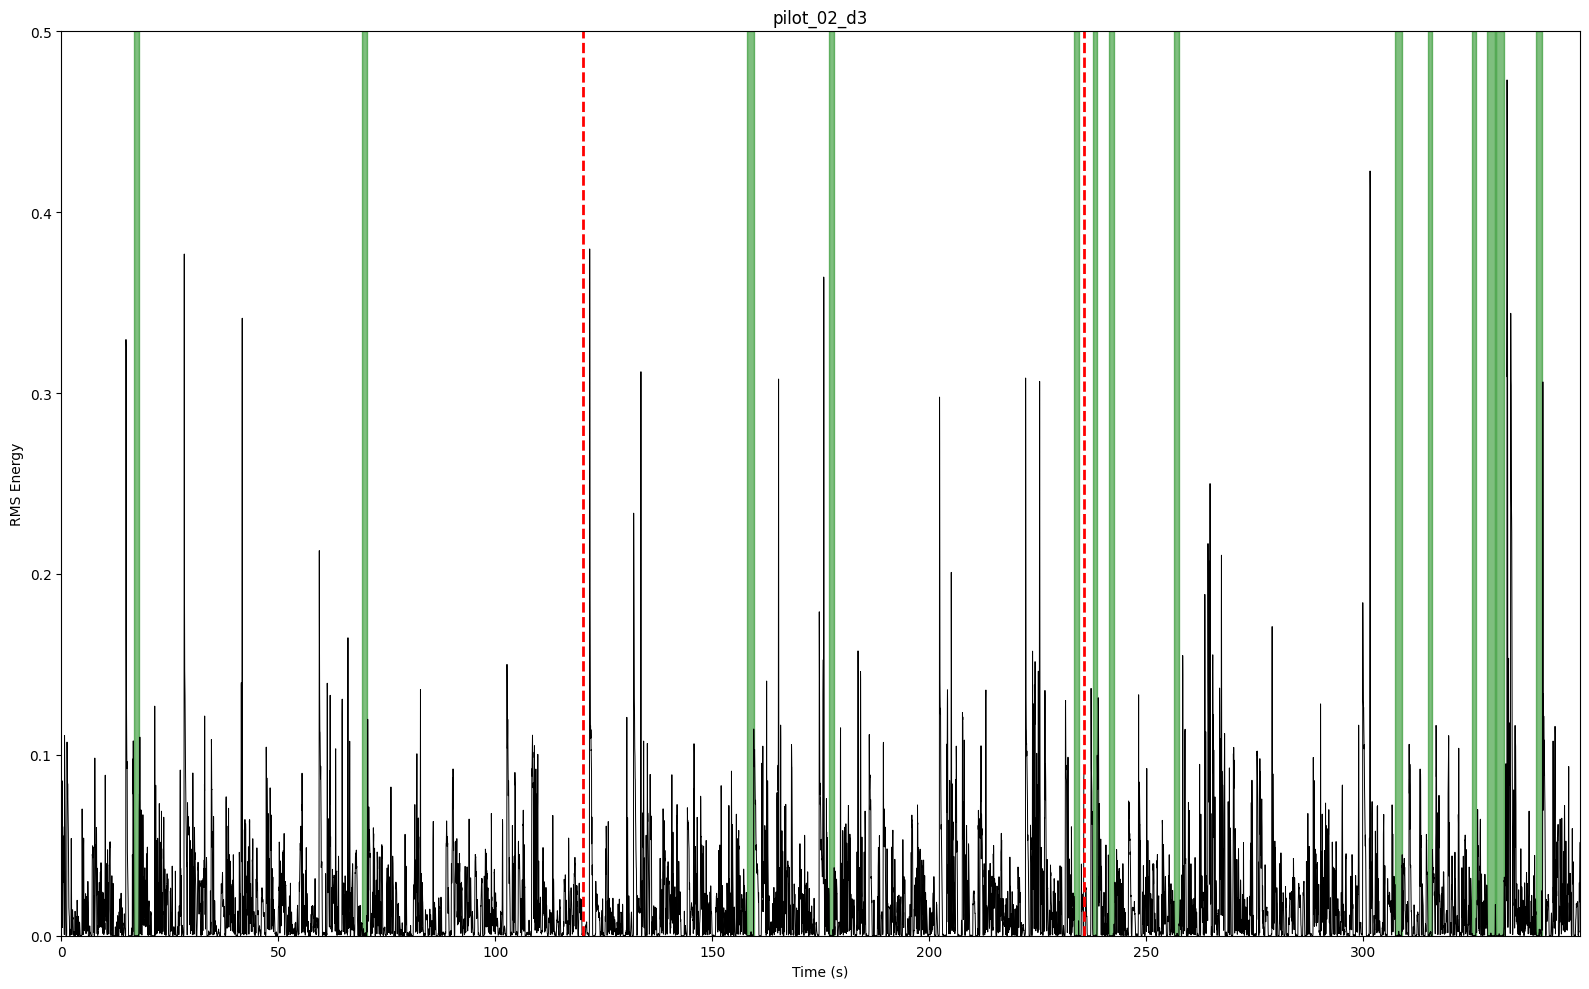

Processing participant session: pilot_04_d2
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_04\\day2\\pilot_04_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_04\day2\pilot_04_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

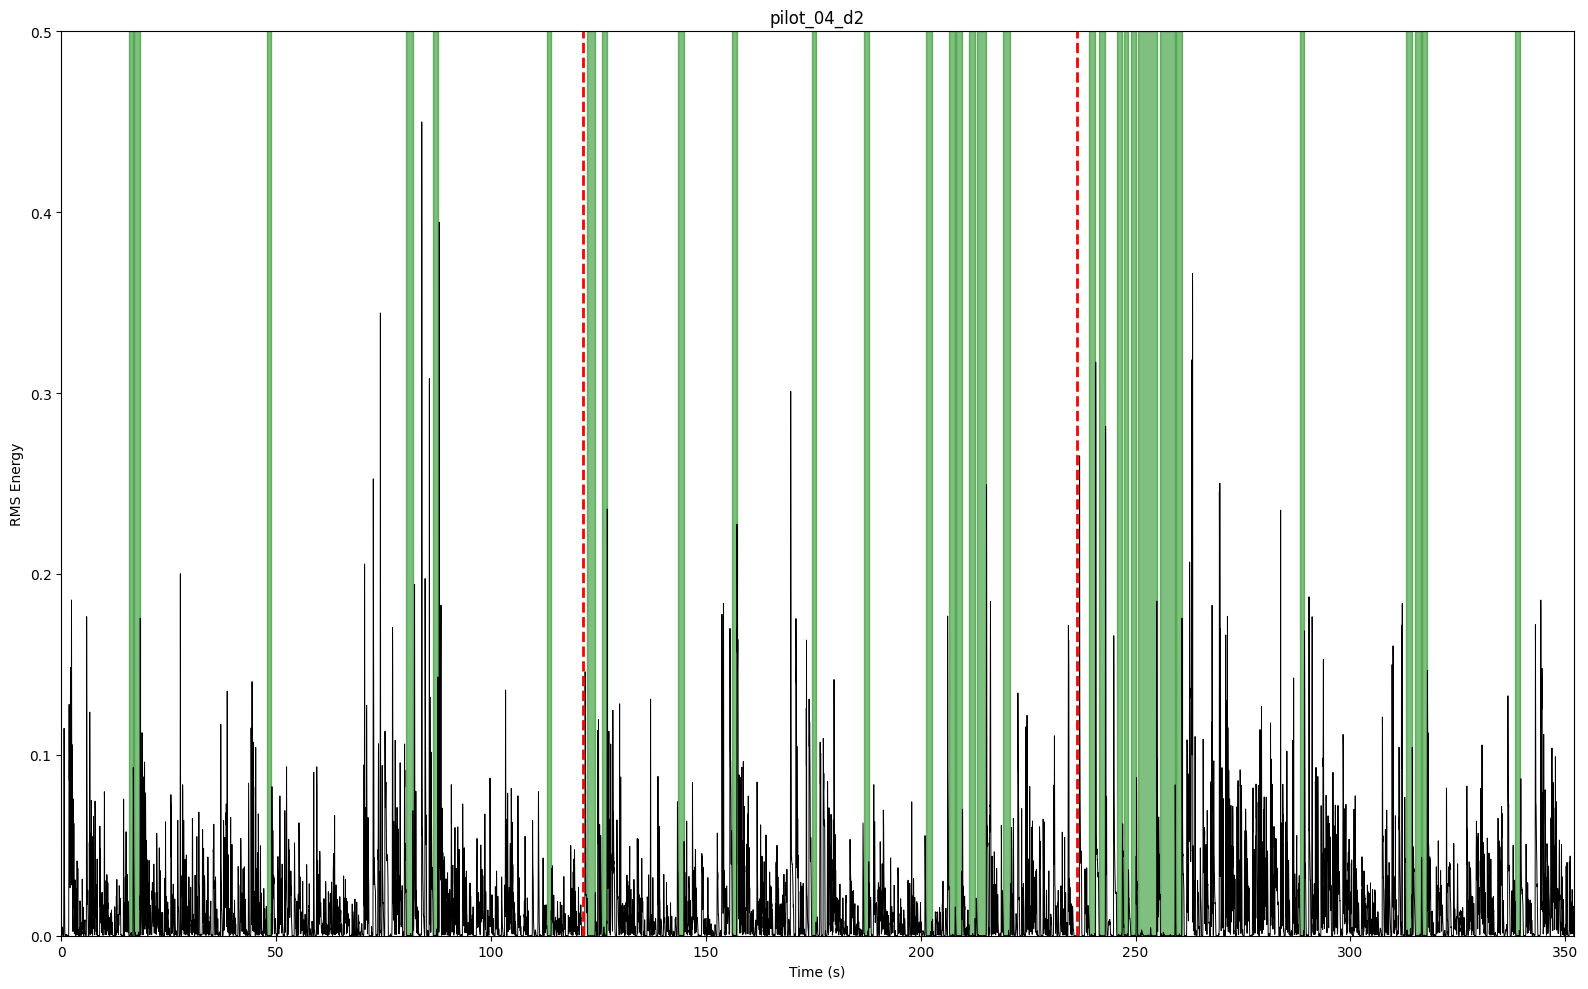

Processing participant session: pilot_05_d2
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_05\\day2\\pilot_05_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_05\day2\pilot_05_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

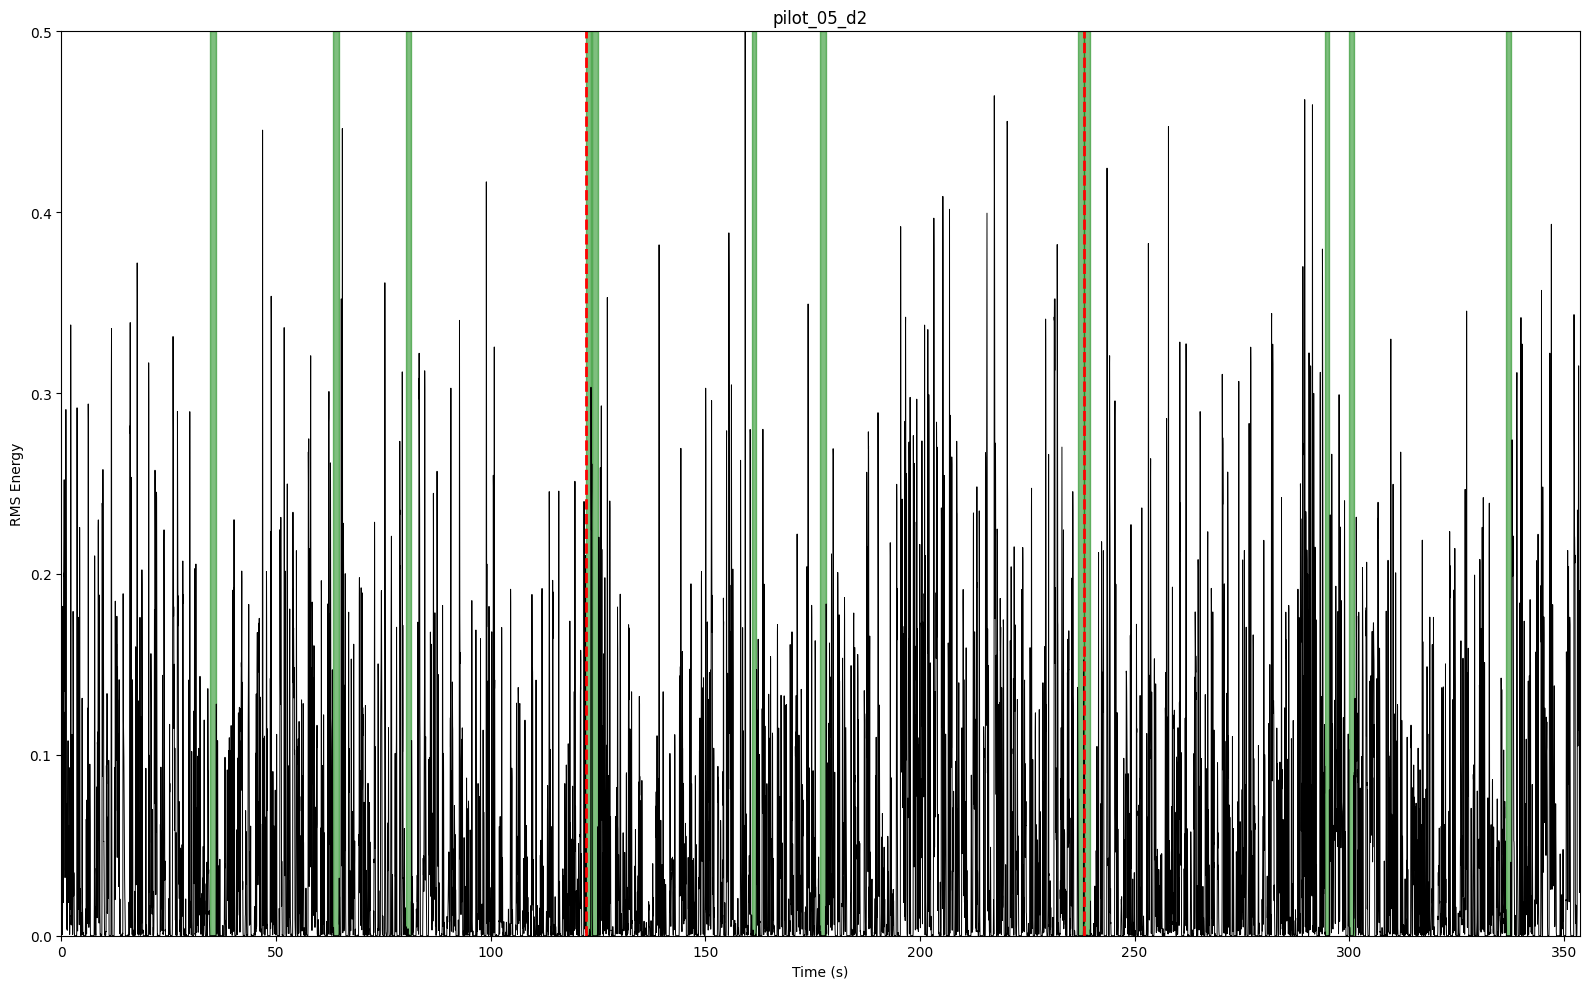

Processing participant session: pilot_06_d2
Sorted files: ['Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_06\\day2\\pilot_06_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_06\\day2\\pilot_06_d2_speech_lsl_Mic_SUD_1_End_SUD_2_Start_denoised.wav', 'Z:\\Davide_MultimodalLab\\2_PREPROCESSING\\1_XDF_PROCESSING\\data_processed_final\\marker_3pairs\\pilot_06\\day2\\pilot_06_d2_speech_lsl_Mic_SUD_2_End_SUD_3_Start_denoised.wav']
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs\pilot_06\day2\pilot_06_d2_speech_lsl_Mic_Speech_Start_SUD_1_Start_denoised.wav
The sampling rate of the raw audio is 16000
Calculating RMS energy for the speech...
Detecting silence periods in the speech...
Loading file: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_fi

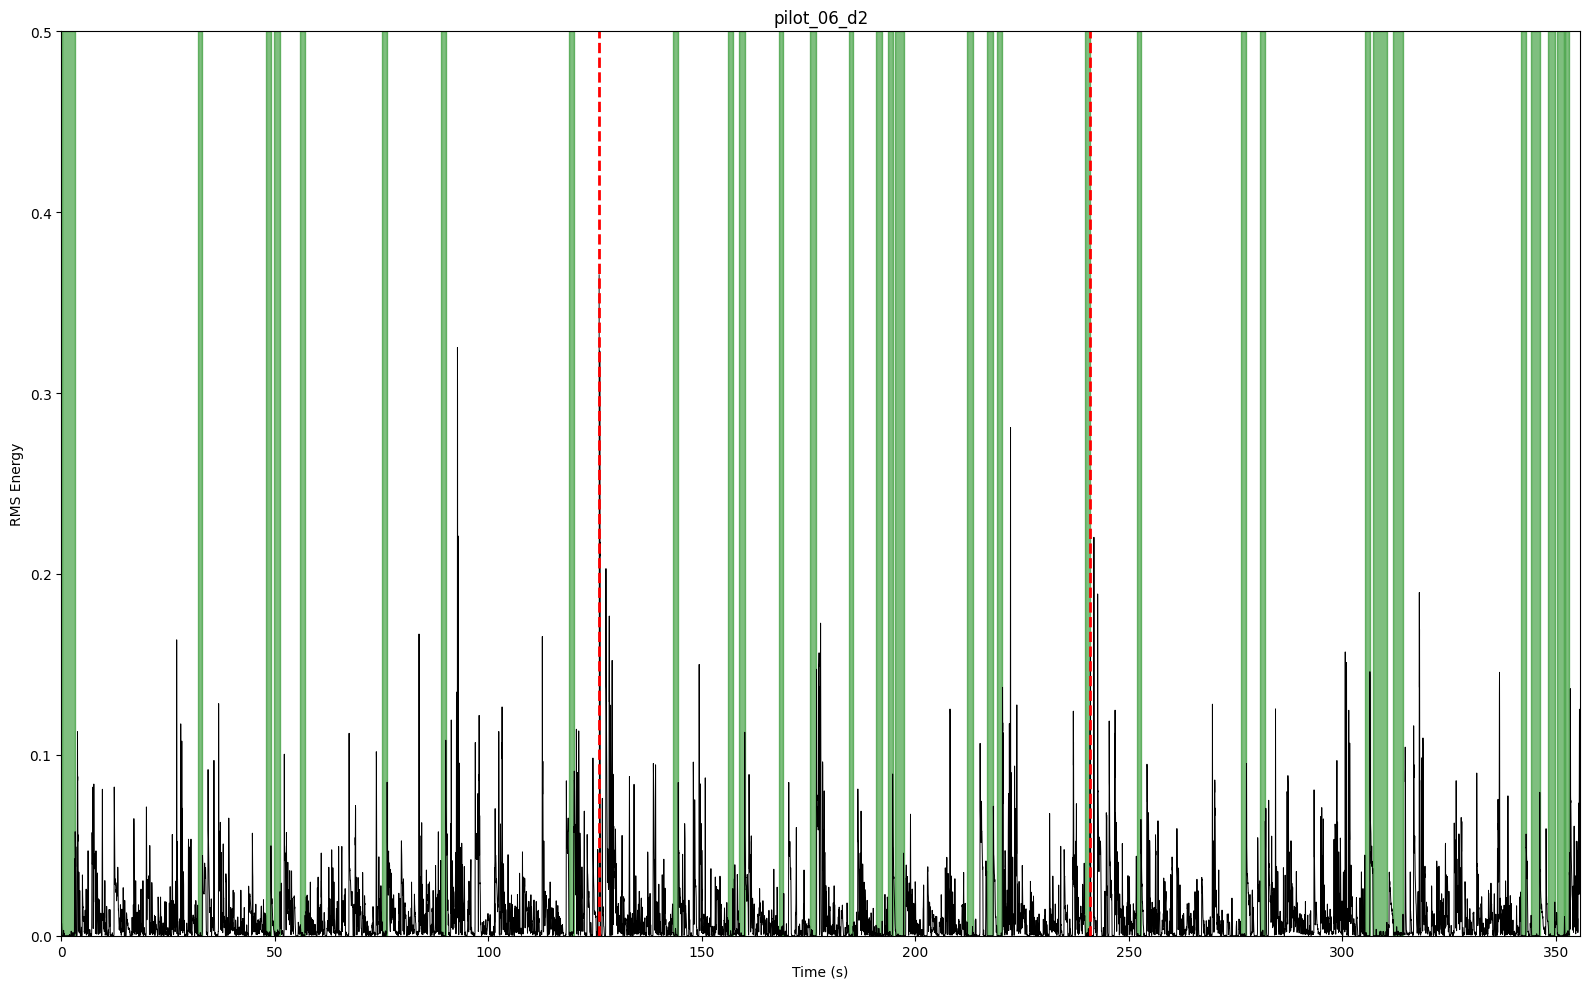

Processing completed successfully!


In [18]:
# List of participants and sessions to process
participants_sessions = [
    'pilot_01_d2', 'pilot_01_d3',
    'pilot_02_d2', 'pilot_02_d3',
    'pilot_04_d2', 'pilot_05_d2', 'pilot_06_d2'
]

# Loop through each participant and session
for participant_session in participants_sessions:
    print(f'Processing participant session: {participant_session}')

    participant_files = []
    for root, dirs, files in os.walk(input_audio_file):  
        for file in files:
            if participant_session in file and 'denoised' in file and file.endswith(".wav"): 
                participant_files.append(os.path.join(root, file))
      
    # Sort files based on naming convention (Speech Start, SUD_1_End, SUD_2_End)
    files_sorted = sorted(participant_files, key=lambda x: ('Speech_Start' in x, 'SUD_1_End' in x, 'SUD_2_End' in x), reverse=True)
    print('Sorted files:', files_sorted)

    # Initialize lists to store RMS and silence periods for all segments
    rms_segments = []
    silence_periods_segments = []
    durations = []

    if not files_sorted:
        print(f"No files found for {participant_session}. Skipping to the next session.")
        continue  # Skip this session if no files are found
    
    # Loop through the three files and load data
    for file in files_sorted:
        file_path = os.path.join(input_audio_file, file)
        print(f'Loading file: {file}')
        
        try:
            # Load audio data
            rawaudio, sr = librosa.load(file_path, sr=None)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
        
        print('The sampling rate of the raw audio is', sr)

        # Calculate RMS for the speech file
        print("Calculating RMS energy for the speech...")
        rms_speech = rms_energy(rawaudio, window_size=int(sr * 0.025))
        rms_time = np.linspace(0, len(rawaudio) / sr, len(rms_speech))
        rms_segments.append((rms_time, rms_speech))

        # Detect silence periods in the speech file based on RMS
        print("Detecting silence periods in the speech...")
        silence_periods = detect_silence_direct(rms_speech, rms_time, sr, threshold = 0.005, min_silence_duration = 1.0)
        silence_periods_segments.append(silence_periods)
        durations.append(rms_time[-1])

    # Plot RMS and silence detection for all segments
    print('Plotting RMS and silence detection for all segments...')
    plt.figure(figsize=(16, 10))
    total_duration = sum(durations)
    segment_boundaries = np.cumsum(durations)

    for i, (rms_data, silence_periods) in enumerate(zip(rms_segments, silence_periods_segments)):
        rms_time, rms_speech = rms_data
        plt.plot(rms_time + sum(durations[:i]), rms_speech, color='black', lw=0.7, label=f'Segment {i + 1}')
        for (start, end) in silence_periods:
            plt.axvspan(start + sum(durations[:i]), end + sum(durations[:i]), color='green', alpha=0.5)

    # Plot vertical lines to divide segments
    for boundary in segment_boundaries[:-1]:
        plt.axvline(boundary, color='red', linestyle='--', lw = 2)

    plt.margins(x=0) # Remove margins
    plt.ylim(0, 0.5) # Set y-axis lower limit to 0 and upper limit to 0.5 (consistent across all plots)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.title(f'{participant_session}')
    plt.tight_layout()

    # Save the RMS and silence detection figure
    rms_plot_filename = f'{participant_session}_RMS_silence_detection.png'
    rms_plot_filepath = os.path.join(figures_results, rms_plot_filename)
    plt.savefig(rms_plot_filepath, dpi = 300)
    plt.show()

print('Processing completed successfully!')


### 2. Filtering Audio Files & Extracting Amplitudes &  Saving as .csv data frame (in loop)

In [ ]:
for root, dirs, files in os.walk(input_audio_file):  # Loop through all files in the input directory
   
    for file in files:                                  # Loop through all files in the input directory
        
        if 'Mic' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
            print("Processing LSL file: ", os.path.basename(file))

            LSL_filename = os.path.join(root, file)
            
            LSL_data = pd.read_csv(LSL_filename)
            
            LSL_Time = LSL_data['LSL_Time']
            
 
       
        if keyword in file and file.endswith(".wav"):   # Check if the file contains the keyword and is a .wav file
            
             # Extract relevant key words from file name to match later with cloud export folder
            fnam = os.path.basename(file)[:-4]    # Extract the file name from the path and assings it to fnam, whilst removing the '.wav' extension (i.e., the last 4 characters in the string)
            participant_num = '_'.join(fnam.split('_')[0:2])  # Extract the participant number from the file name by splitting the string at the underscores and selecting the first two elements
            day_num = fnam.split('_')[2]  # Extract the day number from the file name by splitting the string at the underscores and selecting the third element
            condition = '_'.join(fnam.split('_')[6:10])  # Extract the condition from the file name by splitting the string at the underscores and selecting the relevant parts
            
            audiofilename = os.path.join(root, file)
            
            print("Processing file: ", os.path.basename(audiofilename))
            rawaudio, sr = librosa.load(audiofilename, sr=None)
            print('The sampling rate of the raw audio is', sr)
            
            print("Extracting amplitude envelope...")
            ampv, sr = amp_envelope(audiofilename)
            
            
            # Smooth the amplitude envelope using a moving average filter
            ampv = pd.Series(ampv).rolling(window=100, min_periods=1).mean()
            
            
            
            # Now Saving the Raw Audio and the Amplitude Envelope as a csv data frame with TIME (in seconds) 
            # Create a Audio DataFrame with time (in secs, starting from 0) raw audio and amplitude envelope for later use
            audio_df = pd.DataFrame({'Time (s)': LSL_Time - LSL_Time.iloc[0],
                                     'audio': rawaudio, 
                                     'envelope': ampv})
            audio_df.head()
            
            # outputfilename = f"{participant_num}_{day_num}__{condition}_audio_amp.csv"
            # outputfilepath = os.path.join(output_audio_file, outputfilename)
            # print("Saving raw audio and amplitude envelope to: ", outputfilepath)
            # audio_df.to_csv(outputfilepath, index=False)
            
            
            ## PLOTTING THe Raw Signal with the Amplitude Envelope ### 
            
            # # Plot the raw audio and amplitude envelope together
            # plt.figure(figsize=(12, 6))
            # # plot them together
            # plt.plot(audio_df['Time (s)'], audio_df['audio'], color='black', linewidth = 0.1)
            # plt.plot(audio_df['Time (s)'], audio_df['envelope'], color='red', linewidth = 0.5)
            # plt.title('Raw Audio Signal and Amplitude Envelope')
            # plt.xlabel('Time (s)')
            # plt.ylabel('Amplitude')
            # plt.legend(['Raw Audio', 'Amplitude Envelope'])
            # plt.tight_layout()

            # # save the figure
            # outputfigurename = f"{participant_num}_{day_num}__{condition}_audio_amp.png"
            # outputfigurepath = os.path.join(output_audio_picture, outputfigurename)
            # plt.savefig(outputfigurepath)




            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)
            plt.plot(audio_df['Time (s)'], audio_df['audio'], color='black', linewidth = 0.1)
            plt.title('Raw Audio Signal')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.subplot(2, 1, 2)
            plt.plot(audio_df['Time (s)'], audio_df['envelope'], color='red', linewidth = 0.5)
            plt.title('Amplitude Envelope')
            plt.xlabel('Time (s)')
            plt.ylabel('Amplitude')
            plt.tight_layout()
            
            # save the figure
            outputfigurename = f"{participant_num}_{day_num}__{condition}_audio_amp.png"
            outputfigurepath = os.path.join(output_audio_picture, outputfigurename)
            plt.savefig(outputfigurepath)
            
            plt.show()
        
            
            